# Sentiment Analysis in torchtext

### Imports

In [1]:
'''
    Reference - https://github.com/hpanwar08/sentiment-analysis-torchtext/blob/master/Sentiment_Analysis_torchtext.ipynb
    
    Work on to merge the labels
    Auto + Bank + Employement + BusinessInterview + Economy
    Interview + Opinion + Literature
'''
%matplotlib inline
import os, sys
import re
import string
import pathlib
import random
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torchtext
from torchtext import data
from torchtext import vocab

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
print('Python version:',sys.version)
print('Pandas version:',pd.__version__)
print('Pytorch version:', torch.__version__)
print('Torch Text version:', torchtext.__version__)
print('Spacy version:', spacy.__version__)

Python version: 3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 19:29:21) 
[GCC 7.3.0]
Pandas version: 0.23.4
Pytorch version: 0.4.0
Torch Text version: 0.3.1
Spacy version: 2.0.16


### Load data

In [3]:
data_root = pathlib.Path('./data/raw/')

classes = ['Auto', 'Bank', 'Blog', 'Business Interview',
           'Economy', 'Education', 'Employment', 'Entertainment',
           'Interview', 'Literature', 'National News', 'Opinion',
           'Sports', 'Technology', 'Tourism', 'World']

In [4]:
df = pd.read_csv('./data/raw/train.csv', error_bad_lines=False)
df.shape
df.head()

(10594, 2)

,label,data
0,10,थारु सभासदहरुले कैलालीको टीकापुरमा भएको झडपमा ...
1,10,राजविराज चैत सप्तरी प्रहरीले पातो गाविसबाट स...
2,1,गजेन्द्र बुढाथोकीकाठमाडौं माघ बैंकिङ क्षेत्र...
3,10,उपप्रधानमन्त्री कमल थापाले संविधानमा असहमति हु...
4,10,असोज काठमाडौं अमेरिकी अधिकारीहरुले आधिकारिक ...


In [5]:
df = df.rename(index=str, columns={"data": "SentimentText", "label": "Sentiment"})

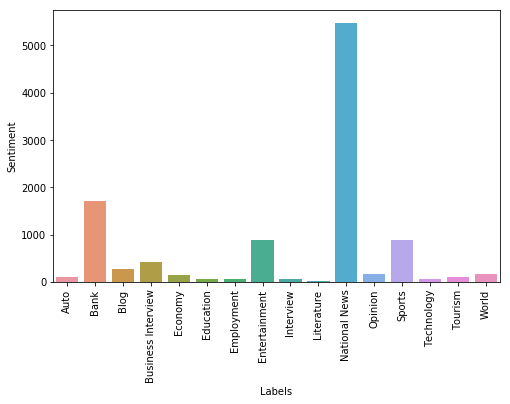

In [6]:
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x=df.Sentiment.unique(), y=df.Sentiment.value_counts());
ax.set_xticklabels(classes, rotation=90)
ax.set(xlabel='Labels');

## Train validation split

##### torchtext have trouble handling \n. Replace \n character with space.

In [7]:
df['SentimentText'] = df.SentimentText.progress_apply(lambda x: re.sub('\n', ' ', x))

Progress: 100%|██████████| 10594/10594 [00:00<00:00, 173136.55it/s]


In [8]:
def split_train_test(df, test_size=0.2):
    train, val = train_test_split(df, test_size=test_size,random_state=42)
    return train.reset_index(drop=True), val.reset_index(drop=True)

In [9]:
traindf, valdf = split_train_test(df, test_size=0.2)

In [10]:
traindf.shape
traindf.Sentiment.value_counts()

(8475, 2)

10    4363
12    1365
7      719
4      697
11     342
1      216
2      134
14     126
15     116
6       88
3       84
13      56
5       54
8       53
0       52
9       10
Name: Sentiment, dtype: int64

In [11]:
valdf.shape
valdf.Sentiment.value_counts()

(2119, 2)

10    1111
12     341
4      181
7      162
11      77
1       54
15      37
14      34
2       27
3       24
6       20
0       16
8       12
5       11
13       9
9        3
Name: Sentiment, dtype: int64

##### Save the train and validation df

In [12]:
traindf.to_csv(data_root/'traindf.csv', index=False)
valdf.to_csv(data_root/'valdf.csv', index=False)

## 1. Define how to process data

##### Preprocessing

In [13]:
# nlp = spacy.load('en',disable=['parser', 'tagger', 'ner'])
# def tokenizer(s): return [w.text.lower() for w in nlp(tweet_clean(s))]

In [14]:
# def tweet_clean(text):
#     text = re.sub(r'[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric character
#     text = re.sub(r'https?:/\/\S+', ' ', text) # remove links
#     return text.strip()

In [15]:
def tokenizer(s): return s.split()

##### Define fields

In [16]:
txt_field = data.Field(sequential=True, tokenize=tokenizer, include_lengths=True, use_vocab=True)
label_field = data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)

train_val_fields = [
    ('Sentiment', label_field),
    ('SentimentText', txt_field)
]

## 2. Create torchtext dataset

In [17]:
%%time
trainds, valds = data.TabularDataset.splits(path=data_root, format='csv', train='traindf.csv', validation='valdf.csv', fields=train_val_fields, skip_header=True)

CPU times: user 1.05 s, sys: 20 ms, total: 1.07 s
Wall time: 1.06 s


In [18]:
len(trainds), len(valds)

(8475, 2119)

In [19]:
ex = trainds[0]
trainds.fields.items()
# ex.Sentiment
# ex.SentimentText

dict_items([('Sentiment', <torchtext.data.field.Field object at 0x3fff7c3117b8>), ('SentimentText', <torchtext.data.field.Field object at 0x3fff7c3117f0>)])

In [20]:
# ex = valds[0]
# ex.Sentiment

## 3. Load pretrained word vectors and building vocabulary

In [21]:
%%time
# vec = vocab.Vectors('glove.twitter.27B.100d.txt', './data/glove_embedding/')
vec = vocab.Vectors('./data/large_nep2vec.txt')

CPU times: user 140 ms, sys: 36 ms, total: 176 ms
Wall time: 165 ms


In [22]:
%%time
txt_field.build_vocab(trainds, valds, max_size=100000, vectors=vec)
label_field.build_vocab(trainds)

CPU times: user 2.37 s, sys: 0 ns, total: 2.37 s
Wall time: 2.37 s


In [23]:
txt_field.vocab.vectors.shape

torch.Size([100002, 100])

In [24]:
txt_field.vocab.vectors[txt_field.vocab.stoi['म']]

tensor([-0.3896,  1.8487, -0.0657,  2.0903,  0.4955, -0.6503, -2.4989,
        -1.6274, -1.0375,  2.6434, -0.8152, -0.2311, -1.8350,  2.2657,
         1.6724,  0.2105, -0.0679,  0.1389,  1.7299,  1.6670,  2.4800,
        -1.7672,  0.3998, -1.1306,  2.3462,  1.5662,  0.6138, -2.6506,
        -2.4233, -2.7957, -1.5976,  2.4225, -2.1781, -0.1329,  2.0305,
         0.4357,  0.8959,  0.2567,  2.7800,  1.6513,  1.5992,  0.5938,
         1.6162, -1.7877,  1.6819, -0.0324, -1.5037, -3.1891,  0.8827,
        -0.2825, -0.7122,  1.1246,  1.4272,  0.8021, -4.1194,  1.4679,
        -2.7505,  1.1685,  3.3379, -0.6846,  1.1243,  2.1203, -1.1586,
        -3.2750, -0.9348,  3.7749,  3.0786, -1.0205,  2.5531, -0.5501,
        -1.1917, -0.0792, -0.7715,  0.3274,  2.7693,  3.8868,  1.0523,
        -1.4871,  0.0718, -0.2615, -0.7815,  1.9536,  0.1851,  0.4665,
         4.1067,  1.0190, -1.7467,  1.5418, -1.7004, -1.5643, -1.1541,
         0.6280, -0.4386,  0.9448,  2.8460,  1.9715, -1.5069, -2.0099,
      

## 4. Loading the data in batches

In [25]:
traindl, valdl = data.BucketIterator.splits(datasets=(trainds, valds), 
                                            batch_sizes=(3,3), 
                                            sort_key=lambda x: len(x.SentimentText), 
                                            device=None, 
                                            sort_within_batch=True, 
                                            repeat=False)

In [26]:
len(traindl), len(valdl)

(2825, 707)

In [27]:
batch = next(iter(traindl))
type(batch)

torchtext.data.batch.Batch

In [28]:
batch.Sentiment

tensor([ 10,  10,  10])

##### returns word indices and lengths

In [29]:
batch.SentimentText

(tensor([[   823,    194,     56],
         [    56,   1948,     57],
         [  1606,    228,   4512],
         [   936,    729,    404],
         [   697,   1806,  29743],
         [  1805,   3673,     10],
         [ 10653,    498,  20435],
         [  5222,   1480,   4486],
         [   130,   1601,   3665],
         [  6658,   1960,    690],
         [ 15491,   3310,    379],
         [  7882,    133,      7],
         [   682,   1184,      2],
         [    95,  34763,    552],
         [  1088,   5830,    489],
         [  4875,   5727,   5137],
         [  4997,  62446,    488],
         [     3,  23288,    245],
         [     0,   3772,   1860],
         [   419,      5,    690],
         [  4033,    608,    379],
         [  3547,    321,      7],
         [    63,  22031,      8],
         [   602,   1144,   1992],
         [     3,    512,  54696],
         [    81,    641,    147],
         [  1460,     95,  25190],
         [ 25015,  62446,    579],
         [   682,  2

In [30]:
batch.dataset.fields

{'Sentiment': <torchtext.data.field.Field at 0x3fff7c3117b8>,
 'SentimentText': <torchtext.data.field.Field at 0x3fff7c3117f0>}

In [31]:
txt_field.vocab.itos[1]

'<pad>'

##### convert index to string

Function to convert batch to text

In [32]:
def idxtosent(batch, idx):
    return ' '.join([txt_field.vocab.itos[i] for i in batch.SentimentText[0][:,idx].cpu().data.numpy()])

In [33]:
idxtosent(batch,0)

'असार काठमाडौं व्यवस्थापिका संसदमा शनिबार विनियोजन विधेयकमाथि छलफलका क्रममा उठेका प्रश्नहरुको मन्त्रीहरुले जवाफ दिने क्रम दिनभर चल्यो र <unk> बैठकमा अन्तिममा सहरी विकास मन्त्रालय र प्रधानमन्त्री कार्यालयको बजेटबारे जवाफ दिन प्रधानमन्त्री केपी शर्मा ओली रोष्टममा उभिए फाइल <unk> ओलीले बोलिरहँदा सांसदहरुले खासै ताली <unk> प्रधानमन्त्रीले बोल्दा ड्याप ड्याप पार्दै समर्थन गर्न एमालेसहितका सत्ता पक्षका दलका सांसदहरुमा पनि जाँगर देखिएन् विकास योजनाबारे निरन्तर बोल्दा पनि ताली नपाएपछि प्रधानमन्त्री ओली आफैैंले बोल्नु पर्ने अवस्था आएको छ उनले हुलाकी राजमार्ग सरकार आफैंले बनाउने र मधेसका जिल्लाहरु सदरमुकामहरुमा पनि चत्रपथ बनाइने बताए तर सांसदहरुले ड्याप ड्याप पारेनन् लगतै प्रधानमन्त्री ओलीले <unk> हेर्दै भने ताली पनि कोही लगाउनु हुन्न के हो यो प्रश्नमा संसदमा हाँसोको फोहोरा छुट्यो र एमाले सांसदहरुले हाँस्दै ड्याप ड्याप पारे लगतै प्रधानमन्त्रीले भने विर्सनु भो कि भनेर सम्झाएको मात्र यसपछि संसदमा फेरि हाँसोको फोहोरा छुट्यो त्यसपछि भने प्रधानमन्त्रीले बोल्दै पिच्छे सत्तारुढ दलका सांसदहरुले ड्याप ड्

In [34]:
val_batch = next(iter(valdl))

##### Note that BucketIterator returns a Batch object instead of text index and labels directly and Batch object is not iterable unlike pytorch Dataloader. A single Batch object contains the data of one batch and the text and labels can be accessed via column names. 
##### This is one of the small hiccups in torchtext. But this can be easily overcome in two ways. Either write some extra code in the training loop for getting the data out of Batch object or write a iterable wrapper around Batch Object that returns the desired data. I will take the second approach as this is much cleaner.

In [35]:
class BatchGenerator:
    def __init__(self, dl, x_field, y_field):
        self.dl, self.x_field, self.y_field = dl, x_field, y_field
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_field)
            yield (X,y)

In [36]:
train_batch_it = BatchGenerator(traindl, 'SentimentText', 'Sentiment')

## 5. Finally Model and training

In [37]:
vocab_size = len(txt_field.vocab)
embedding_dim = 100
n_hidden = 64
n_out = len(classes)

## Simple RNN module

#### Simple GRU model

In [38]:
class SimpleGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, bidirectional=True):
        super().__init__()
        self.vocab_size,self.embedding_dim,self.n_hidden,self.n_out,self.bidirectional = vocab_size, embedding_dim, n_hidden, n_out, bidirectional
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        self.out = nn.Linear(self.n_hidden, self.n_out)
        
    def forward(self, seq, lengths):
        bs = seq.size(1) # batch size
        seq = seq.transpose(0,1)
        self.h = self.init_hidden(bs) # initialize hidden state of GRU
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        embs = pack_padded_sequence(embs, lengths) # unpad
        gru_out, self.h = self.gru(embs, self.h) # gru returns hidden state of all timesteps as well as hidden state at last timestep
        gru_out, lengths = pad_packed_sequence(gru_out) # pad the sequence to the max length in the batch
        # since it is as classification problem, we will grab the last hidden state
        outp = self.out(self.h[-1]) # self.h[-1] contains hidden state of last timestep
#         return F.log_softmax(outp, dim=-1)
        return F.log_softmax(outp)
    
    def init_hidden(self, batch_size): 
        if self.bidirectional:
            return torch.zeros((2,batch_size,self.n_hidden)).to(device)
        else:
            return torch.zeros((1,batch_size,self.n_hidden)).to(device)

#### RNN Model

In [39]:
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, bidirectional=True):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.bidirectional = bidirectional
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        self.rnn = nn.RNN(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        self.out = nn.Linear(self.n_hidden, self.n_out)
        
    def forward(self, seq, lengths):
        bs = seq.size(1) # batch size
        seq = seq.transpose(0,1)
        self.h = self.init_hidden(bs) # initialize hidden state of GRU
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        embs = pack_padded_sequence(embs, lengths) # unpad
        rnn_out, self.h = self.rnn(embs, self.h) # gru returns hidden state of all timesteps as well as hidden state at last timestep
        rnn_out, lengths = pad_packed_sequence(rnn_out) # pad the sequence to the max length in the batch
        # since it is as classification problem, we will grab the last hidden state
        outp = self.out(self.h[-1]) # self.h[-1] contains hidden state of last timestep
#         return F.log_softmax(outp, dim=-1)
        return F.log_softmax(outp)
    
    def init_hidden(self, batch_size): 
        if self.bidirectional:
            return torch.zeros((2,batch_size,self.n_hidden)).to(device)
        else:
            return torch.zeros((1,batch_size,self.n_hidden)).to(device)

#### LSTM Model

In [141]:
class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, bidirectional=True):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.bidirectional = bidirectional
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        self.lstm = nn.LSTM(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        self.out = nn.Linear(self.n_hidden, self.n_out)
        
    def forward(self, seq, lengths):
        bs = seq.size(1) # batch size
        seq = seq.transpose(0,1)
        self.h = self.init_hidden(bs) # initialize hidden state of GRU
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        embs = pack_padded_sequence(embs, lengths) # unpad
        lstm_out, self.h = self.lstm(embs, self.h) # gru returns hidden state of all timesteps as well as hidden state at last timestep
        lstm_out, lengths = pad_packed_sequence(lstm_out) # pad the sequence to the max length in the batch
        outp = self.out(self.h[0][-1]) # self.h[-1] contains hidden state of last timestep
        return F.log_softmax(outp)
        
    def init_hidden(self, batch_size): 
        if self.bidirectional:
            h0 = Variable(torch.zeros(2, batch_size, self.n_hidden)).to(device)
            c0 = Variable(torch.zeros(2, batch_size, self.n_hidden)).to(device)
        else:
            h0 = Variable(torch.zeros(1, batch_size, self.n_hidden)).to(device)
            c0 = Variable(torch.zeros(1, batch_size, self.n_hidden)).to(device)
        return (h0, c0)

#### Concat Pooling model

In [40]:
class ConcatPoolingGRUAdaptive(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, bidirectional=True):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.bidirectional = bidirectional
        
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        if bidirectional:
            self.out = nn.Linear(self.n_hidden*2*2, self.n_out)
        else:
            self.out = nn.Linear(self.n_hidden*2, self.n_out)
        
    def forward(self, seq, lengths):
        bs = seq.size(1)
        self.h = self.init_hidden(bs)
        seq = seq.transpose(0,1)
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        embs = pack_padded_sequence(embs, lengths)
        gru_out, self.h = self.gru(embs, self.h)
        gru_out, lengths = pad_packed_sequence(gru_out)        
        
        avg_pool = F.adaptive_avg_pool1d(gru_out.permute(1,2,0),1).view(bs,-1)
        max_pool = F.adaptive_max_pool1d(gru_out.permute(1,2,0),1).view(bs,-1)        
        outp = self.out(torch.cat([avg_pool,max_pool],dim=1))
        return F.log_softmax(outp)
    
    def init_hidden(self, batch_size): 
        if self.bidirectional:
            return torch.zeros((2,batch_size,self.n_hidden)).to(device)
        else:
            return torch.zeros((1,batch_size,self.n_hidden)).cuda().to(device)

#### Training function

In [41]:
def fit(model, train_dl, val_dl, loss_fn, opt, epochs=3):
    total_train_loss = []
    total_train_acc = []
    total_val_loss = []
    total_val_acc = []
    num_batch = len(train_dl)
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0          
        
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        for (X,lengths),y in t:
            t.set_description(f'Epoch {epoch}')
            lengths = lengths.cpu().numpy()
            
            opt.zero_grad()
            pred = model(X, lengths)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            
            t.set_postfix(loss=loss.item())
            pred_idx = torch.max(pred, dim=1)[1]
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred_idx.cpu().data.numpy())
            total_loss_train += loss.item()
            
        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl)
        total_train_loss.append(train_loss)
        total_train_acc.append(train_acc)
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for (X,lengths),y in tqdm_notebook(val_dl, leave=False):
                pred = model(X, lengths.cpu().numpy())
                loss = loss_fn(pred, y)
                pred_idx = torch.max(pred, 1)[1]
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred_idx.cpu().data.numpy())
                total_loss_val += loss.item()
            valacc = accuracy_score(y_true_val, y_pred_val)
            valloss = total_loss_val/len(valdl)
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {valloss:.4f} val_acc: {valacc:.4f}')
        else:
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f}')
        total_val_loss.append(valloss)
        total_val_acc.append(valacc)
            
    return model, total_train_loss, total_train_acc, total_val_loss, total_val_acc

##### Dataloader

In [42]:
traindl, valdl = data.BucketIterator.splits(datasets=(trainds, valds), 
                                            batch_sizes=(512,1024), 
                                            sort_key=lambda x: len(x.SentimentText), 
                                            device=device, 
                                            sort_within_batch=True, 
                                            repeat=False)

train_batch_it = BatchGenerator(traindl, 'SentimentText', 'Sentiment')
val_batch_it = BatchGenerator(valdl, 'SentimentText', 'Sentiment')

#### Plot loss

In [162]:
def plot_loss(train_loss, val_loss, title):
    plt.figure(figsize=[8,5])
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()

#### REVIEW PREDICTION

In [149]:
# Testing with random new review
review = ["सत्ताधारी नेपाल कम्युनिस्ट पार्टी (नेकपा) का प्रवक्ताले निकै विवादित बन्न पुगेको एशिया प्यासिफिक सम्मेलन हुने कुरा चल्दा नै आफूले पार्टीभित्र आपत्ति जनाए पनि सुनुवाइ नभएको बताएका छन्।",
         "आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।",
         "बोर्डले यसलाई ऐतिहासिक उपलब्धी भनेको छ। यो संख्या अघिल्लो वर्ष सन् २०१७को भन्दा १७ प्रतिशतले बढी हो। यो तथ्यांकमा अक्टोबर र नोभेम्बरमा पैदलमार्गबाट आएका पर्यटकको संख्या सामेल छैन । यो संख्या पनि जोड्दा जनवरीदेखि नोभेम्बरसम्ममा नै करिब २३ प्रतिशत वृद्धि देखिने बोर्डको आंकलन छ। "]

# Print the prediction of new reviews
def print_prediction(review=review, model=gru_model):
    for each_review in review:
        original_review = each_review
        each_review = txt_field.preprocess(each_review)
        each_review = [[txt_field.vocab.stoi[x] for x in each_review]]
        each_review = np.asarray(each_review)
        each_review = Variable(torch.LongTensor(each_review), volatile=True).to(device)
        model.eval()
        output = model(each_review, torch.ones((len(each_review[0])), dtype=torch.long))
        label = torch.argmax(output[0])
        print("{0}: {1}\n".format(original_review, classes[label]))

#### LOAD/SAVE MODEL

In [150]:
def save_checkpoint(model, train_loss, train_acc, val_loss, val_acc, filename):
    save_parameters = {'model': model,
                      'train_loss' : train_loss,
                      'train_acc' : train_acc,
                      'val_loss' : val_loss,
                      'val_acc' : val_acc}
    torch.save(save_parameters, filename)
    
    
def load_checkpoint(filename):
    checkpoint = torch.load(filename)
    
    model = checkpoint['model']
    train_loss = checkpoint['train_loss']
    train_acc = checkpoint['train_acc']
    val_loss = checkpoint['val_loss']
    val_acc = checkpoint['val_acc']
    
    return model, train_loss, train_acc, val_loss, val_acc

#### GRU SECTION

In [189]:
gru_model = SimpleGRU(vocab_size, embedding_dim, n_hidden, n_out, trainds.fields['SentimentText'].vocab.vectors).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, gru_model.parameters()), 1e-3)
gru_model_file = './data/models/gru_model.pth'

In [190]:
gru_model, gru_train_loss, gru_train_acc, gru_val_loss, gru_val_acc = fit(model=gru_model, train_dl=train_batch_it, 
                                                                       val_dl=val_batch_it, loss_fn=F.nll_loss, 
                                                                       opt=opt, epochs=40)

Epoch 0: train_loss: 2.1470 train_acc: 0.4617 | val_loss: 1.9776 val_acc: 0.5281


Epoch 1: train_loss: 1.6586 train_acc: 0.5156 | val_loss: 1.9177 val_acc: 0.5257


Epoch 2: train_loss: 1.5632 train_acc: 0.5244 | val_loss: 1.8870 val_acc: 0.5540


Epoch 3: train_loss: 1.5232 train_acc: 0.5528 | val_loss: 1.8220 val_acc: 0.5635


Epoch 4: train_loss: 1.4498 train_acc: 0.5756 | val_loss: 1.7849 val_acc: 0.5842


Epoch 5: train_loss: 1.3889 train_acc: 0.5890 | val_loss: 1.7271 val_acc: 0.6022


Epoch 6: train_loss: 1.3215 train_acc: 0.6077 | val_loss: 1.6802 val_acc: 0.6248


Epoch 7: train_loss: 1.2532 train_acc: 0.6309 | val_loss: 1.5970 val_acc: 0.6508


Epoch 8: train_loss: 1.1885 train_acc: 0.6454 | val_loss: 1.5634 val_acc: 0.6560


Epoch 9: train_loss: 1.1346 train_acc: 0.6641 | val_loss: 1.4904 val_acc: 0.6730


Epoch 10: train_loss: 1.0858 train_acc: 0.6712 | val_loss: 1.4960 val_acc: 0.6630


Epoch 11: train_loss: 1.0921 train_acc: 0.6720 | val_loss: 1.4213 val_acc: 0.6895


Epoch 12: train_loss: 1.0188 train_acc: 0.6847 | val_loss: 1.4255 val_acc: 0.6899


Epoch 13: train_loss: 0.9882 train_acc: 0.6971 | val_loss: 1.3789 val_acc: 0.6899


Epoch 14: train_loss: 0.9652 train_acc: 0.7010 | val_loss: 1.3310 val_acc: 0.7088


Epoch 15: train_loss: 0.9419 train_acc: 0.7108 | val_loss: 1.2995 val_acc: 0.7159


Epoch 16: train_loss: 0.9311 train_acc: 0.7102 | val_loss: 1.2597 val_acc: 0.7074


Epoch 17: train_loss: 0.8926 train_acc: 0.7193 | val_loss: 1.2768 val_acc: 0.7239


Epoch 18: train_loss: 0.8631 train_acc: 0.7344 | val_loss: 1.2126 val_acc: 0.7390


Epoch 19: train_loss: 0.8447 train_acc: 0.7406 | val_loss: 1.1717 val_acc: 0.7386


Epoch 20: train_loss: 0.8338 train_acc: 0.7438 | val_loss: 1.1691 val_acc: 0.7244


Epoch 21: train_loss: 0.8200 train_acc: 0.7487 | val_loss: 1.1286 val_acc: 0.7437


Epoch 22: train_loss: 0.8001 train_acc: 0.7507 | val_loss: 1.1338 val_acc: 0.7456


Epoch 23: train_loss: 0.7854 train_acc: 0.7568 | val_loss: 1.0892 val_acc: 0.7598


Epoch 24: train_loss: 0.7607 train_acc: 0.7694 | val_loss: 1.0759 val_acc: 0.7598


Epoch 25: train_loss: 0.7454 train_acc: 0.7691 | val_loss: 1.1058 val_acc: 0.7513


Epoch 26: train_loss: 0.7685 train_acc: 0.7641 | val_loss: 1.0645 val_acc: 0.7579


Epoch 27: train_loss: 0.7288 train_acc: 0.7776 | val_loss: 1.0286 val_acc: 0.7622


Epoch 28: train_loss: 0.7111 train_acc: 0.7771 | val_loss: 1.0065 val_acc: 0.7664


Epoch 29: train_loss: 0.7006 train_acc: 0.7827 | val_loss: 1.0177 val_acc: 0.7659


Epoch 30: train_loss: 0.6923 train_acc: 0.7847 | val_loss: 0.9799 val_acc: 0.7706


Epoch 31: train_loss: 0.6981 train_acc: 0.7851 | val_loss: 1.0229 val_acc: 0.7522


Epoch 32: train_loss: 0.6790 train_acc: 0.7883 | val_loss: 0.9822 val_acc: 0.7730


Epoch 33: train_loss: 0.6506 train_acc: 0.8018 | val_loss: 0.9609 val_acc: 0.7716


Epoch 34: train_loss: 0.6442 train_acc: 0.8020 | val_loss: 0.9445 val_acc: 0.7735


Epoch 35: train_loss: 0.6337 train_acc: 0.8012 | val_loss: 0.9517 val_acc: 0.7749


Epoch 36: train_loss: 0.6313 train_acc: 0.8014 | val_loss: 0.9484 val_acc: 0.7697


Epoch 37: train_loss: 0.6167 train_acc: 0.8031 | val_loss: 0.9314 val_acc: 0.7777


Epoch 38: train_loss: 0.6078 train_acc: 0.8087 | val_loss: 0.9291 val_acc: 0.7787


Epoch 39: train_loss: 0.6077 train_acc: 0.8076 | val_loss: 0.9206 val_acc: 0.7744


In [191]:
save_checkpoint(gru_model, gru_train_loss, gru_train_acc, gru_val_loss, gru_val_acc, gru_model_file)

gru_model, gru_train_loss, gru_train_acc, gru_val_loss, gru_val_acc = load_checkpoint(gru_model_file)

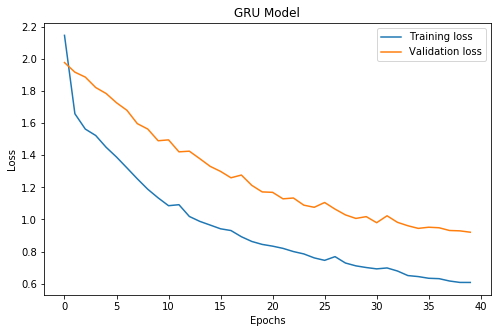

In [192]:
plot_loss(gru_train_loss, gru_val_loss, title='GRU Model')

In [201]:
print_prediction(review=review, model=gru_model)

सत्ताधारी नेपाल कम्युनिस्ट पार्टी (नेकपा) का प्रवक्ताले निकै विवादित बन्न पुगेको एशिया प्यासिफिक सम्मेलन हुने कुरा चल्दा नै आफूले पार्टीभित्र आपत्ति जनाए पनि सुनुवाइ नभएको बताएका छन्।: Sports

आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।: Sports

बोर्डले यसलाई ऐतिहासिक उपलब्धी भनेको छ। यो संख्या अघिल्लो वर्ष सन् २०१७को भन्दा १७ प्रतिशतले बढी हो। यो तथ्यांकमा अक्टोबर र नोभेम्बरमा पैदलमार्गबाट आएका पर्यटकको संख्या सामेल छैन । यो संख्या पनि जोड्दा जनवरीदेखि नोभेम्बरसम्ममा नै करिब २३ प्रतिशत वृद्धि देखिने बोर्डको आंकलन छ। : Sports



In [198]:
print("GRU Validation accuracy", gru_val_acc[-1])

GRU Validation accuracy 0.7744218971212836


#### RNN SECTION

In [202]:
rnn_model = SimpleRNN(vocab_size, embedding_dim, n_hidden, n_out, trainds.fields['SentimentText'].vocab.vectors).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, rnn_model.parameters()), 1e-3)

rnn_model_file = './data/models/rnn_model.pth'
rnn_model, rnn_train_loss, rnn_train_acc, rnn_val_loss, rnn_val_acc = fit(model=rnn_model, train_dl=train_batch_it, val_dl=val_batch_it, loss_fn=F.nll_loss, opt=opt, epochs=40)

Epoch 0: train_loss: 2.1485 train_acc: 0.4417 | val_loss: 2.0031 val_acc: 0.5224


Epoch 1: train_loss: 1.7002 train_acc: 0.5124 | val_loss: 1.9273 val_acc: 0.5300


Epoch 2: train_loss: 1.5956 train_acc: 0.5228 | val_loss: 1.9147 val_acc: 0.5432


Epoch 3: train_loss: 1.5525 train_acc: 0.5355 | val_loss: 1.8672 val_acc: 0.5635


Epoch 4: train_loss: 1.5122 train_acc: 0.5626 | val_loss: 1.8443 val_acc: 0.5706


Epoch 5: train_loss: 1.4770 train_acc: 0.5680 | val_loss: 1.8677 val_acc: 0.5828


Epoch 6: train_loss: 1.4374 train_acc: 0.5822 | val_loss: 1.8017 val_acc: 0.5908


Epoch 7: train_loss: 1.4094 train_acc: 0.5907 | val_loss: 1.7800 val_acc: 0.5951


Epoch 8: train_loss: 1.3911 train_acc: 0.5873 | val_loss: 1.7992 val_acc: 0.5880


Epoch 9: train_loss: 1.3777 train_acc: 0.5878 | val_loss: 1.6959 val_acc: 0.5993


Epoch 10: train_loss: 1.3289 train_acc: 0.5979 | val_loss: 1.6991 val_acc: 0.5998


Epoch 11: train_loss: 1.3051 train_acc: 0.6048 | val_loss: 1.6630 val_acc: 0.6154


Epoch 12: train_loss: 1.3025 train_acc: 0.6077 | val_loss: 1.6610 val_acc: 0.6017


Epoch 13: train_loss: 1.2856 train_acc: 0.6156 | val_loss: 1.5941 val_acc: 0.6192


Epoch 14: train_loss: 1.2456 train_acc: 0.6224 | val_loss: 1.5838 val_acc: 0.6239


Epoch 15: train_loss: 1.2182 train_acc: 0.6314 | val_loss: 1.5888 val_acc: 0.6248


Epoch 16: train_loss: 1.2037 train_acc: 0.6379 | val_loss: 1.6128 val_acc: 0.6343


Epoch 17: train_loss: 1.1788 train_acc: 0.6444 | val_loss: 1.5543 val_acc: 0.6390


Epoch 18: train_loss: 1.1581 train_acc: 0.6533 | val_loss: 1.5658 val_acc: 0.6465


Epoch 19: train_loss: 1.1551 train_acc: 0.6520 | val_loss: 1.5412 val_acc: 0.6494


Epoch 20: train_loss: 1.1449 train_acc: 0.6498 | val_loss: 1.5153 val_acc: 0.6508


Epoch 21: train_loss: 1.1236 train_acc: 0.6602 | val_loss: 1.5646 val_acc: 0.6395


Epoch 22: train_loss: 1.1623 train_acc: 0.6438 | val_loss: 1.5043 val_acc: 0.6484


Epoch 23: train_loss: 1.1284 train_acc: 0.6578 | val_loss: 1.4782 val_acc: 0.6484


Epoch 24: train_loss: 1.1550 train_acc: 0.6472 | val_loss: 1.5483 val_acc: 0.6437


Epoch 25: train_loss: 1.1001 train_acc: 0.6618 | val_loss: 1.4804 val_acc: 0.6456


Epoch 26: train_loss: 1.0882 train_acc: 0.6651 | val_loss: 1.5196 val_acc: 0.6461


Epoch 27: train_loss: 1.0830 train_acc: 0.6688 | val_loss: 1.4827 val_acc: 0.6541


Epoch 28: train_loss: 1.0947 train_acc: 0.6648 | val_loss: 1.4348 val_acc: 0.6574


Epoch 29: train_loss: 1.0607 train_acc: 0.6735 | val_loss: 1.4772 val_acc: 0.6498


Epoch 30: train_loss: 1.0635 train_acc: 0.6724 | val_loss: 1.4399 val_acc: 0.6569


Epoch 31: train_loss: 1.0505 train_acc: 0.6760 | val_loss: 1.4408 val_acc: 0.6654


Epoch 32: train_loss: 1.0386 train_acc: 0.6795 | val_loss: 1.4170 val_acc: 0.6635


Epoch 33: train_loss: 1.0398 train_acc: 0.6779 | val_loss: 1.4539 val_acc: 0.6673


Epoch 34: train_loss: 1.0490 train_acc: 0.6761 | val_loss: 1.4224 val_acc: 0.6668


Epoch 35: train_loss: 1.0278 train_acc: 0.6834 | val_loss: 1.4489 val_acc: 0.6564


Epoch 36: train_loss: 1.0406 train_acc: 0.6765 | val_loss: 1.4396 val_acc: 0.6645


Epoch 37: train_loss: 1.0209 train_acc: 0.6813 | val_loss: 1.4087 val_acc: 0.6635


Epoch 38: train_loss: 1.0124 train_acc: 0.6802 | val_loss: 1.4454 val_acc: 0.6616


Epoch 39: train_loss: 1.0171 train_acc: 0.6812 | val_loss: 1.4368 val_acc: 0.6522


In [204]:
save_checkpoint(rnn_model, rnn_train_loss, rnn_train_acc, rnn_val_loss, rnn_val_acc, rnn_model_file)

rnn_model, rnn_train_loss, rnn_train_acc, rnn_val_loss, rnn_val_acc = load_checkpoint(rnn_model_file)

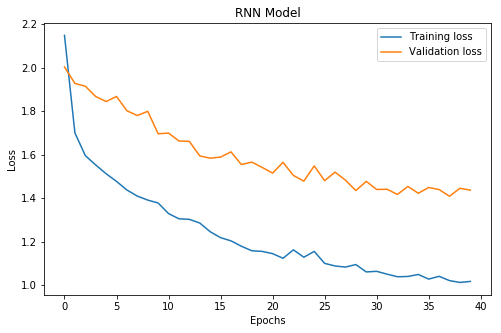

In [205]:
plot_loss(rnn_train_loss, rnn_val_loss, title='RNN Model')

In [206]:
print("RNN Validation accuracy", rnn_val_acc[-1])

RNN Validation accuracy 0.6521944313355357


In [207]:
print_prediction(model=rnn_model)

सत्ताधारी नेपाल कम्युनिस्ट पार्टी (नेकपा) का प्रवक्ताले निकै विवादित बन्न पुगेको एशिया प्यासिफिक सम्मेलन हुने कुरा चल्दा नै आफूले पार्टीभित्र आपत्ति जनाए पनि सुनुवाइ नभएको बताएका छन्।: National News

आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।: National News

बोर्डले यसलाई ऐतिहासिक उपलब्धी भनेको छ। यो संख्या अघिल्लो वर्ष सन् २०१७को भन्दा १७ प्रतिशतले बढी हो। यो तथ्यांकमा अक्टोबर र नोभेम्बरमा पैदलमार्गबाट आएका पर्यटकको संख्या सामेल छैन । यो संख्या पनि जोड्दा जनवरीदेखि नोभेम्बरसम्ममा नै करिब २३ प्रतिशत वृद्धि देखिने बोर्डको आंकलन छ। : Sports



#### ConcatPoolingGRUAdaptive Section

In [208]:
gru_a_model = ConcatPoolingGRUAdaptive(vocab_size, embedding_dim, n_hidden, n_out, trainds.fields['SentimentText'].vocab.vectors).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, gru_a_model.parameters()), 1e-3)

gru_a_model_file = './data/models/rnn_model.pth'
gru_a_model, gru_a_train_loss, gru_a_train_acc, gru_a_val_loss, gru_a_val_acc = fit(model=gru_a_model, train_dl=train_batch_it, val_dl=val_batch_it, loss_fn=F.nll_loss, opt=opt, epochs=40)

Epoch 0: train_loss: 1.9234 train_acc: 0.5115 | val_loss: 2.1450 val_acc: 0.5243


Epoch 1: train_loss: 1.6457 train_acc: 0.5217 | val_loss: 1.9993 val_acc: 0.5356


Epoch 2: train_loss: 1.4998 train_acc: 0.5529 | val_loss: 1.8931 val_acc: 0.5493


Epoch 3: train_loss: 1.3957 train_acc: 0.5927 | val_loss: 1.8248 val_acc: 0.5795


Epoch 4: train_loss: 1.3266 train_acc: 0.6099 | val_loss: 1.7382 val_acc: 0.5913


Epoch 5: train_loss: 1.2291 train_acc: 0.6321 | val_loss: 1.6750 val_acc: 0.6078


Epoch 6: train_loss: 1.2100 train_acc: 0.6369 | val_loss: 1.5991 val_acc: 0.6225


Epoch 7: train_loss: 1.1322 train_acc: 0.6582 | val_loss: 1.6155 val_acc: 0.6234


Epoch 8: train_loss: 1.0860 train_acc: 0.6677 | val_loss: 1.5100 val_acc: 0.6286


Epoch 9: train_loss: 1.0558 train_acc: 0.6747 | val_loss: 1.4925 val_acc: 0.6446


Epoch 10: train_loss: 1.0270 train_acc: 0.6813 | val_loss: 1.4523 val_acc: 0.6338


Epoch 11: train_loss: 1.0112 train_acc: 0.6854 | val_loss: 1.4617 val_acc: 0.6531


Epoch 12: train_loss: 0.9989 train_acc: 0.6878 | val_loss: 1.3597 val_acc: 0.6517


Epoch 13: train_loss: 0.9591 train_acc: 0.7003 | val_loss: 1.3803 val_acc: 0.6630


Epoch 14: train_loss: 0.9455 train_acc: 0.6995 | val_loss: 1.3272 val_acc: 0.6692


Epoch 15: train_loss: 0.9281 train_acc: 0.7037 | val_loss: 1.3187 val_acc: 0.6498


Epoch 16: train_loss: 0.8798 train_acc: 0.7123 | val_loss: 1.2778 val_acc: 0.6626


Epoch 17: train_loss: 0.8588 train_acc: 0.7179 | val_loss: 1.2583 val_acc: 0.6701


Epoch 18: train_loss: 0.8380 train_acc: 0.7278 | val_loss: 1.2552 val_acc: 0.6588


Epoch 19: train_loss: 0.8414 train_acc: 0.7261 | val_loss: 1.2273 val_acc: 0.6597


Epoch 20: train_loss: 0.8266 train_acc: 0.7288 | val_loss: 1.2614 val_acc: 0.6560


Epoch 21: train_loss: 0.8017 train_acc: 0.7323 | val_loss: 1.1863 val_acc: 0.6767


Epoch 22: train_loss: 0.7869 train_acc: 0.7386 | val_loss: 1.1793 val_acc: 0.6838


Epoch 23: train_loss: 0.7733 train_acc: 0.7402 | val_loss: 1.1685 val_acc: 0.6871


Epoch 24: train_loss: 0.7428 train_acc: 0.7588 | val_loss: 1.1369 val_acc: 0.6871


Epoch 25: train_loss: 0.7233 train_acc: 0.7581 | val_loss: 1.1460 val_acc: 0.6852


Epoch 26: train_loss: 0.7088 train_acc: 0.7663 | val_loss: 1.1042 val_acc: 0.6933


Epoch 27: train_loss: 0.7010 train_acc: 0.7680 | val_loss: 1.1365 val_acc: 0.6800


Epoch 28: train_loss: 0.6995 train_acc: 0.7659 | val_loss: 1.1100 val_acc: 0.6862


Epoch 29: train_loss: 0.6793 train_acc: 0.7726 | val_loss: 1.0766 val_acc: 0.6989


Epoch 30: train_loss: 0.6589 train_acc: 0.7814 | val_loss: 1.0712 val_acc: 0.6989


Epoch 31: train_loss: 0.6517 train_acc: 0.7809 | val_loss: 1.0486 val_acc: 0.7107


Epoch 32: train_loss: 0.6496 train_acc: 0.7843 | val_loss: 1.0207 val_acc: 0.7178


Epoch 33: train_loss: 0.6377 train_acc: 0.7861 | val_loss: 1.0417 val_acc: 0.7003


Epoch 34: train_loss: 0.6285 train_acc: 0.7896 | val_loss: 1.0280 val_acc: 0.7074


Epoch 35: train_loss: 0.6219 train_acc: 0.7912 | val_loss: 0.9999 val_acc: 0.7230


Epoch 36: train_loss: 0.6075 train_acc: 0.7948 | val_loss: 1.0026 val_acc: 0.7131


Epoch 37: train_loss: 0.5992 train_acc: 0.8025 | val_loss: 0.9923 val_acc: 0.7187


Epoch 38: train_loss: 0.5919 train_acc: 0.8005 | val_loss: 0.9902 val_acc: 0.7277


Epoch 39: train_loss: 0.5821 train_acc: 0.8070 | val_loss: 0.9628 val_acc: 0.7225


In [209]:
save_checkpoint(gru_a_model, gru_a_train_loss, gru_a_train_acc, gru_a_val_loss, gru_a_val_acc, gru_a_model_file)

gru_a_model, gru_a_train_loss, gru_a_train_acc, gru_a_val_loss, gru_a_val_acc = load_checkpoint(gru_a_model_file)

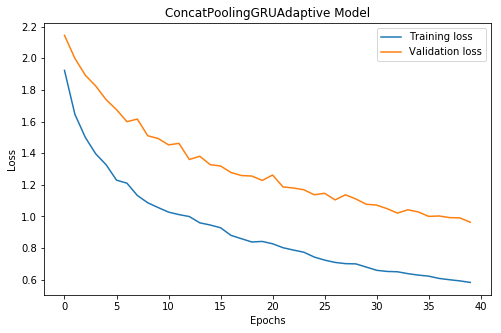

In [210]:
plot_loss(gru_a_train_loss, gru_a_val_loss, title='ConcatPoolingGRUAdaptive Model')

In [211]:
print_prediction(model=gru_a_model)

सत्ताधारी नेपाल कम्युनिस्ट पार्टी (नेकपा) का प्रवक्ताले निकै विवादित बन्न पुगेको एशिया प्यासिफिक सम्मेलन हुने कुरा चल्दा नै आफूले पार्टीभित्र आपत्ति जनाए पनि सुनुवाइ नभएको बताएका छन्।: Sports

आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।: Sports

बोर्डले यसलाई ऐतिहासिक उपलब्धी भनेको छ। यो संख्या अघिल्लो वर्ष सन् २०१७को भन्दा १७ प्रतिशतले बढी हो। यो तथ्यांकमा अक्टोबर र नोभेम्बरमा पैदलमार्गबाट आएका पर्यटकको संख्या सामेल छैन । यो संख्या पनि जोड्दा जनवरीदेखि नोभेम्बरसम्ममा नै करिब २३ प्रतिशत वृद्धि देखिने बोर्डको आंकलन छ। : Sports



In [212]:
print("ConcatPoolingGRUAdaptive Validation accuracy", gru_a_val_acc[-1])

ConcatPoolingGRUAdaptive Validation accuracy 0.7225106182161397


#### LSTM SECTION

In [171]:
lstm_model = SimpleLSTM(vocab_size, embedding_dim, n_hidden, n_out, trainds.fields['SentimentText'].vocab.vectors).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, lstm_model.parameters()), 1e-3)
lstm_model_file = './data/models/lstm_model.pth'

In [173]:
lstm_model, lstm_train_loss, lstm_train_acc, lstm_val_loss, lstm_val_acc = fit(model=lstm_model, train_dl=train_batch_it, val_dl=val_batch_it, loss_fn=F.nll_loss, opt=opt, epochs=40)

Epoch 0: train_loss: 0.4329 train_acc: 0.8628 | val_loss: 1.0091 val_acc: 0.7636


Epoch 1: train_loss: 0.4206 train_acc: 0.8651 | val_loss: 1.0482 val_acc: 0.7697


Epoch 2: train_loss: 0.4161 train_acc: 0.8673 | val_loss: 0.9933 val_acc: 0.7579


Epoch 3: train_loss: 0.4126 train_acc: 0.8684 | val_loss: 0.9919 val_acc: 0.7683


Epoch 4: train_loss: 0.4039 train_acc: 0.8749 | val_loss: 1.0972 val_acc: 0.7588


Epoch 5: train_loss: 0.4289 train_acc: 0.8625 | val_loss: 1.1236 val_acc: 0.7159


Epoch 6: train_loss: 0.5887 train_acc: 0.8071 | val_loss: 0.9962 val_acc: 0.7537


Epoch 7: train_loss: 0.5066 train_acc: 0.8380 | val_loss: 0.9941 val_acc: 0.7711


Epoch 8: train_loss: 0.4732 train_acc: 0.8466 | val_loss: 0.9575 val_acc: 0.7636


Epoch 9: train_loss: 0.4397 train_acc: 0.8572 | val_loss: 0.9924 val_acc: 0.7659


Epoch 10: train_loss: 0.4136 train_acc: 0.8676 | val_loss: 1.0583 val_acc: 0.7697


Epoch 11: train_loss: 0.3937 train_acc: 0.8758 | val_loss: 1.0101 val_acc: 0.7603


Epoch 12: train_loss: 0.6264 train_acc: 0.7955 | val_loss: 1.4215 val_acc: 0.7249


Epoch 13: train_loss: 0.6051 train_acc: 0.8025 | val_loss: 1.2093 val_acc: 0.7400


Epoch 14: train_loss: 0.5548 train_acc: 0.8191 | val_loss: 1.1115 val_acc: 0.7570


Epoch 15: train_loss: 0.4903 train_acc: 0.8404 | val_loss: 1.0895 val_acc: 0.7612


Epoch 16: train_loss: 0.4532 train_acc: 0.8531 | val_loss: 1.0984 val_acc: 0.7631


Epoch 17: train_loss: 0.4456 train_acc: 0.8590 | val_loss: 1.1361 val_acc: 0.7612


Epoch 18: train_loss: 0.4171 train_acc: 0.8677 | val_loss: 1.1013 val_acc: 0.7631


Epoch 19: train_loss: 0.3963 train_acc: 0.8729 | val_loss: 1.0858 val_acc: 0.7650


Epoch 20: train_loss: 0.3782 train_acc: 0.8801 | val_loss: 1.0296 val_acc: 0.7716


Epoch 21: train_loss: 0.3640 train_acc: 0.8835 | val_loss: 1.0885 val_acc: 0.7673


Epoch 22: train_loss: 0.3575 train_acc: 0.8881 | val_loss: 1.0424 val_acc: 0.7631


Epoch 23: train_loss: 0.3482 train_acc: 0.8899 | val_loss: 1.0607 val_acc: 0.7603


Epoch 24: train_loss: 0.3472 train_acc: 0.8906 | val_loss: 1.0956 val_acc: 0.7655


Epoch 25: train_loss: 0.3325 train_acc: 0.8966 | val_loss: 1.0806 val_acc: 0.7640


Epoch 26: train_loss: 0.3355 train_acc: 0.8943 | val_loss: 1.0736 val_acc: 0.7518


Epoch 27: train_loss: 0.3462 train_acc: 0.8914 | val_loss: 1.1029 val_acc: 0.7603


Epoch 28: train_loss: 0.3299 train_acc: 0.8939 | val_loss: 1.0925 val_acc: 0.7636


Epoch 29: train_loss: 0.3133 train_acc: 0.9048 | val_loss: 1.0893 val_acc: 0.7593


Epoch 30: train_loss: 0.2995 train_acc: 0.9101 | val_loss: 1.1169 val_acc: 0.7598


Epoch 31: train_loss: 0.3050 train_acc: 0.9088 | val_loss: 1.1269 val_acc: 0.7603


Epoch 32: train_loss: 0.2995 train_acc: 0.9123 | val_loss: 1.1094 val_acc: 0.7565


Epoch 33: train_loss: 0.3039 train_acc: 0.9062 | val_loss: 1.0793 val_acc: 0.7565


Epoch 34: train_loss: 0.3116 train_acc: 0.9051 | val_loss: 1.1052 val_acc: 0.7636


Epoch 35: train_loss: 0.2884 train_acc: 0.9159 | val_loss: 1.1292 val_acc: 0.7612


Epoch 36: train_loss: 0.2726 train_acc: 0.9196 | val_loss: 1.1363 val_acc: 0.7570


Epoch 37: train_loss: 0.2650 train_acc: 0.9237 | val_loss: 1.1280 val_acc: 0.7626


Epoch 38: train_loss: 0.2574 train_acc: 0.9267 | val_loss: 1.1876 val_acc: 0.7570


Epoch 39: train_loss: 0.2473 train_acc: 0.9306 | val_loss: 1.1911 val_acc: 0.7664


In [174]:
save_checkpoint(lstm_model, lstm_train_loss, lstm_train_acc, lstm_val_loss, lstm_val_acc, lstm_model_file)

lstm_model, lstm_train_loss, lstm_train_acc, lstm_val_loss, lstm_val_acc = load_checkpoint(lstm_model_file)

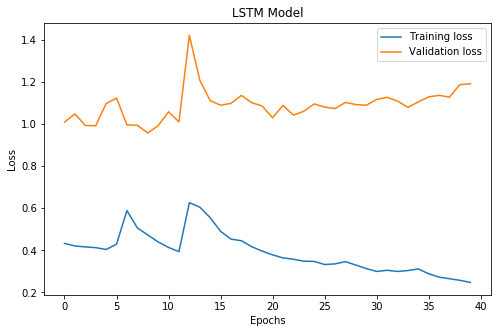

In [175]:
plot_loss(lstm_train_loss, lstm_val_loss, title='LSTM Model')

In [186]:
new_review = ["मेक्सिकोबाट बाबु र अरु दर्जनौं व्यक्तिसँगै गैरकानुनी रुपमा अमेरिका प्रवेश गरेकी ती बालिकाको शरीरमा पानीको मात्रा कम हुने समस्याबाट मृत्यु भएको अमेरिकी भन्सार तथा सीमा सुरक्षा निकायले जनाएको छ । उक्त निकायले ती बालिकाले धेरै दिनदेखि केही नखाएको र पानी समेत नपिएको बताएको छ । पक्राउ परेलगत्तै त्रसित मुद्रामा देखिएकी ती बालिकामा एकाएक काँप्ने समस्या देखिएको, र उपचारका लागि स्थानीय अस्पतालमा पुर्‍याएलगत्तै मृत्यु भएको सीमा सुरक्षा निकायले जनाएको छ । राष्ट्रपति डोनाल्ड ट्रम्पले मेक्सिकोबाट अमेरिका प्रवेश गर्न खोज्ने व्यक्तिलाई अवैध आप्रवासीको संज्ञा दिँदै उनीहरुलाई अमेरिका प्रवेश गरेमा पक्राउ गरी फर्काइदिने चेतावनी दिएका छन् । उनले हजारौं अमेरिकी सुरक्षा फौजलाई मेक्सिकोसँगको सीमामा तैनाथ गरेका छन् । "]

print_prediction(review = new_review, model=lstm_model)

मेक्सिकोबाट बाबु र अरु दर्जनौं व्यक्तिसँगै गैरकानुनी रुपमा अमेरिका प्रवेश गरेकी ती बालिकाको शरीरमा पानीको मात्रा कम हुने समस्याबाट मृत्यु भएको अमेरिकी भन्सार तथा सीमा सुरक्षा निकायले जनाएको छ । उक्त निकायले ती बालिकाले धेरै दिनदेखि केही नखाएको र पानी समेत नपिएको बताएको छ । पक्राउ परेलगत्तै त्रसित मुद्रामा देखिएकी ती बालिकामा एकाएक काँप्ने समस्या देखिएको, र उपचारका लागि स्थानीय अस्पतालमा पुर्‍याएलगत्तै मृत्यु भएको सीमा सुरक्षा निकायले जनाएको छ । राष्ट्रपति डोनाल्ड ट्रम्पले मेक्सिकोबाट अमेरिका प्रवेश गर्न खोज्ने व्यक्तिलाई अवैध आप्रवासीको संज्ञा दिँदै उनीहरुलाई अमेरिका प्रवेश गरेमा पक्राउ गरी फर्काइदिने चेतावनी दिएका छन् । उनले हजारौं अमेरिकी सुरक्षा फौजलाई मेक्सिकोसँगको सीमामा तैनाथ गरेका छन् । : National News



In [213]:
print("LSTM Validation accuracy", lstm_val_acc[-1])

LSTM Validation accuracy 0.7663992449268523
